# Image Classification



- Tao Tang (University of Notre Dame)


## 1. Project Problem Statement
US Department of transportation is converting an existing state highway US 60/93 from Phoenix, AZ to Las Vegas, NV via Wickenburg, AZ and Kingsman, AZ into a new Interstate highway I-11. It is a 4 lane highway, which passes through green farms, cattle farms and ranches, near Wickenburg, AZ. Recently lots of traffic incidents have been reported where pet animals especially dogs and horses have been found wandering and crossing the highway. This has caused a sudden rise in safety related incidents, frequent collisions and accidents.

DOT wants to establish an image recognition solution which could do following:
1. Ability to capture images of pets and stray animals crossing the Interstate Highway.
2. Ability to correctly identify dogs and horses from the images being taken
3. Ability to identify dogs and horses through their ID tags. It may enable DoT to reach
out to their owners to warn them, and in turn minimize the occurrence of such traffic
incidents. (future project)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier,
                            GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import accuracy_score


from tensorflow.keras.datasets import cifar10
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, 
                                    Flatten, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout


## 2. Get the data

In [2]:
#loading the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3) (50000, 1) (10000, 1)


In [3]:
##Count for each images
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 5000,
 1: 5000,
 2: 5000,
 3: 5000,
 4: 5000,
 5: 5000,
 6: 5000,
 7: 5000,
 8: 5000,
 9: 5000}

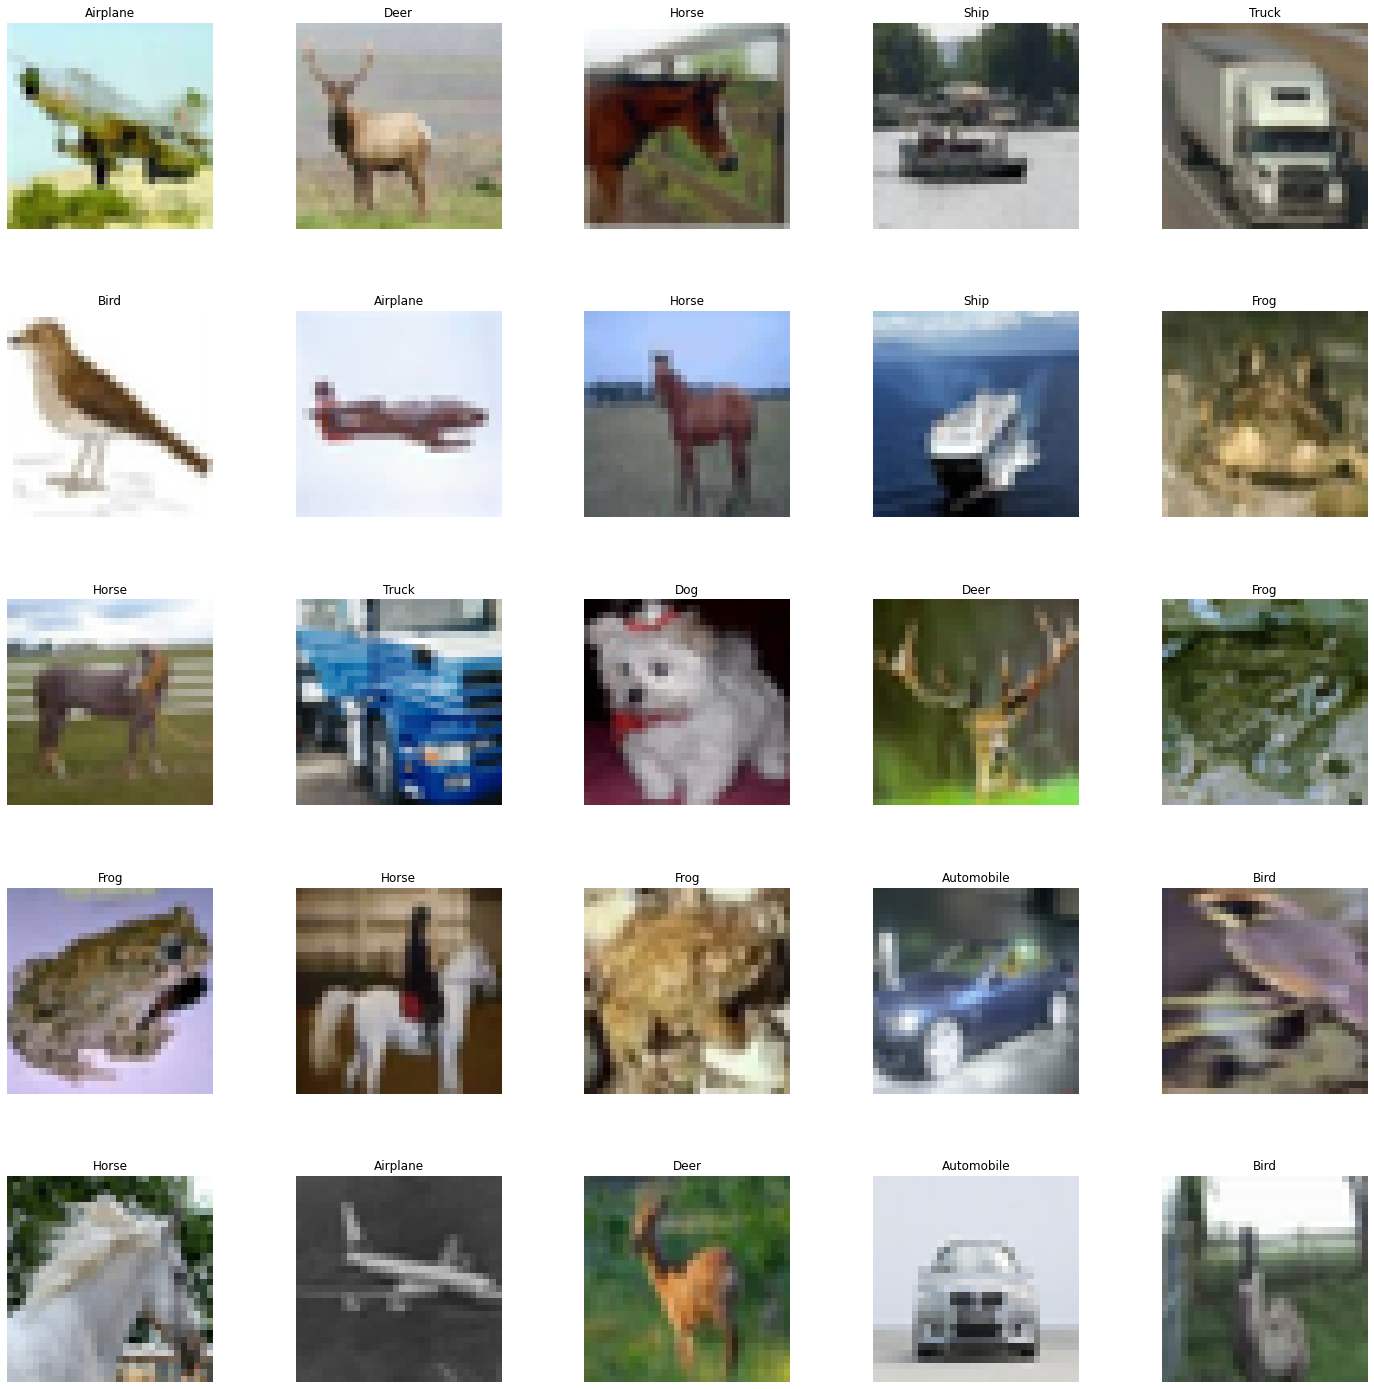

In [4]:
#visualizing few samples of whole data set
labels = ['Airplane', 'Automobile', 'Bird', 
          'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 
          'Ship', 'Truck']

fig, axes = plt.subplots(5, 5, figsize = (25, 25))
axes = axes.ravel()

n_training = len(X_train)

for i in range(0,5*5):
    index = np.random.randint(0,n_training) # pick a random number
    axes[i].imshow(X_train[index])
    index = y_train[index]
    axes[i].set_title(labels[int(index)])
    axes[i].axis('off')
    
plt.subplots_adjust(hspace = 0.4)

### Only extract dog and horse images

In [5]:
## Filter training and test sets to dog and horse
dog = 5
horse = 7

train_ind = np.where((y_train==dog) | (y_train == horse))[0]
test_ind = np.where((y_test==dog) | (y_test == horse))[0]

X_train = X_train[train_ind]
y_train = y_train[train_ind]

X_test = X_test[test_ind]
y_test = y_test[test_ind]

In [6]:
#train and test shape
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(10000, 32, 32, 3) (10000, 1) (2000, 32, 32, 3) (2000, 1)


### Relabel the data

In [7]:
##Relabel dog as 0 and horse as 1 for binary classification
y_train[y_train == dog]=0
y_train[y_train == horse]=1
y_test[y_test == dog]=0
y_test[y_test== horse]=1


In [8]:
##Flatten
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [9]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(10000, 3072) (10000, 1) (2000, 3072) (2000, 1)


### Split the data

In [10]:
#Create validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, 
                                                      y_train, 
                                                      test_size=0.2, 
                                                      stratify = y_train, 
                                                      random_state=2020)
print(X_train.shape, X_valid.shape,X_test.shape,
      y_train.shape,y_valid.shape, y_test.shape)

(8000, 3072) (2000, 3072) (2000, 3072) (8000, 1) (2000, 1) (2000, 1)


## 3. Exploratory Data Analysis (EDA)

[1]


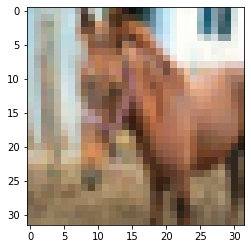

In [11]:
#plot the first image of training data set.
plt.imshow(X_train[0].reshape(32,32,3))
print(y_train[0])

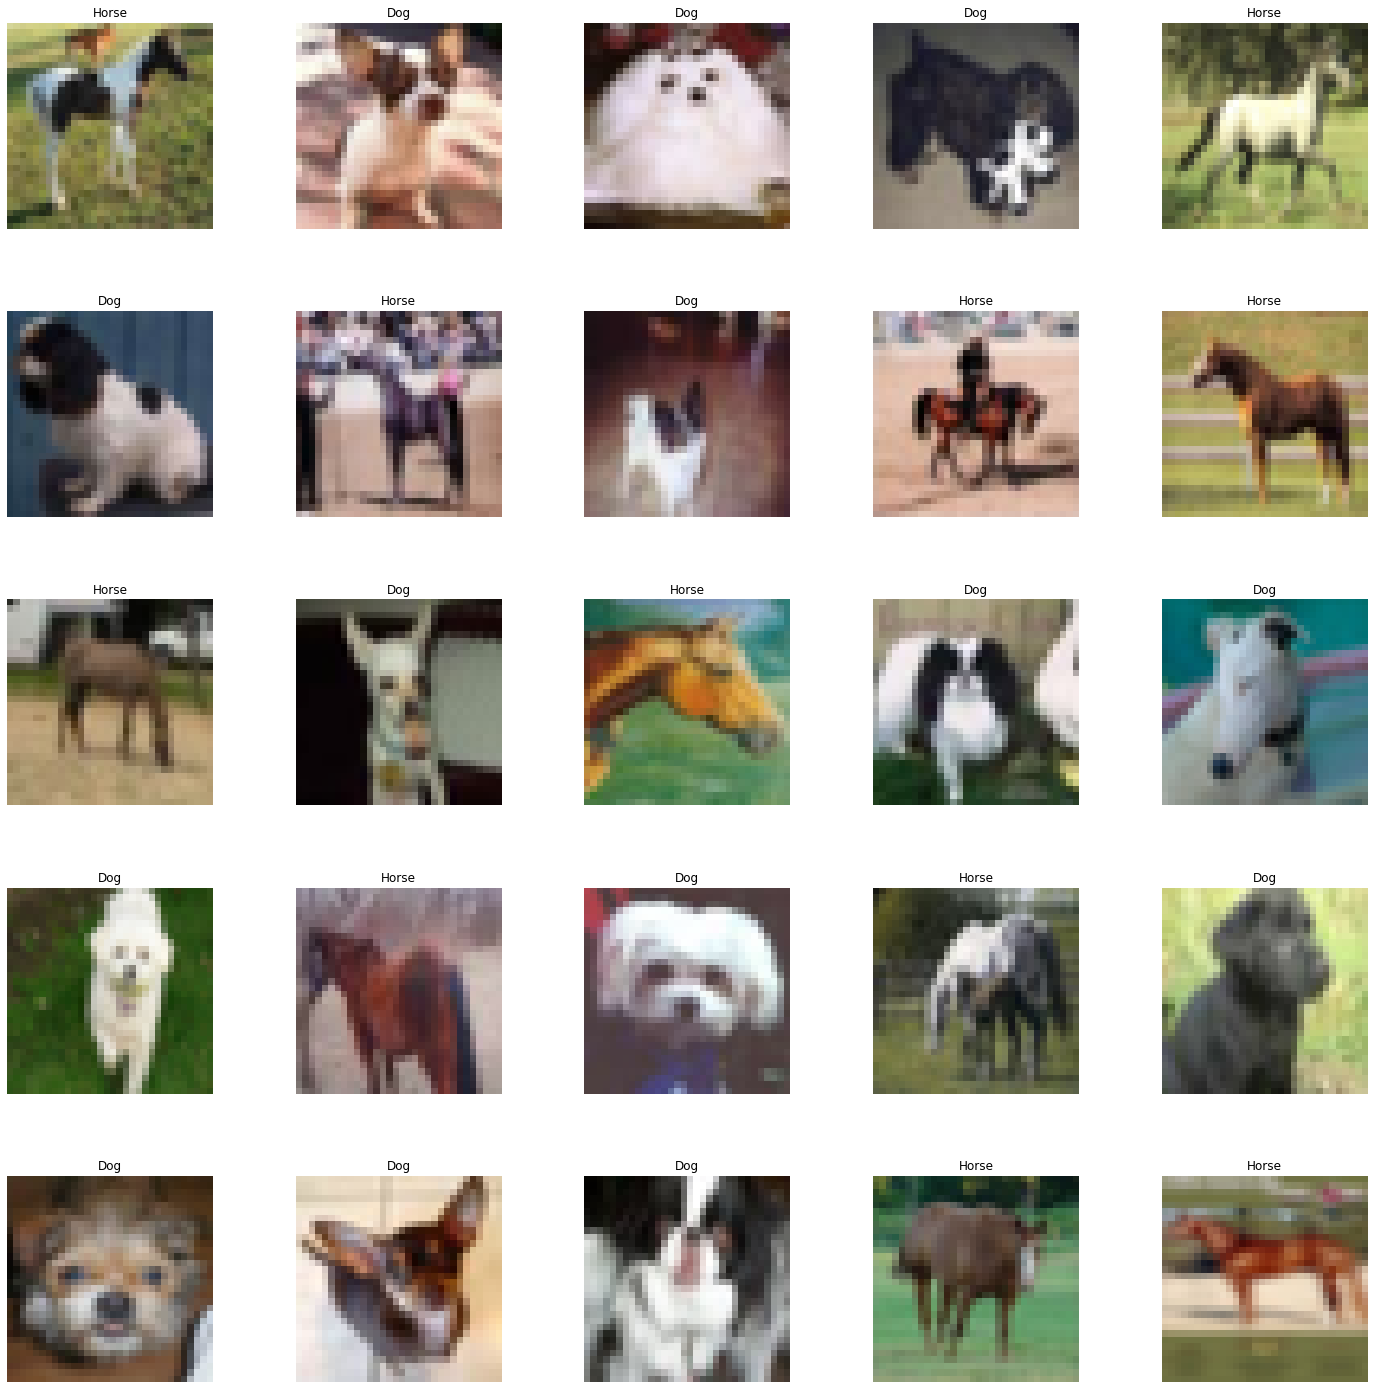

In [12]:
##Plot some images of dog and horse
labels2 = ['Dog', 'Horse']

fig, axes = plt.subplots(5, 5, figsize = (25, 25))
axes = axes.ravel()

n_training = len(X_train)

for i in range(0,5*5):
    index = np.random.randint(0,n_training) # pick a random number
    axes[i].imshow(X_train[index].reshape(32,32,3))
    index = y_train[index]
    axes[i].set_title(labels2[int(index)])
    axes[i].axis('off')
    
plt.subplots_adjust(hspace = 0.4)

## 4. Preprocessing

There are 3072 columns in the data set. In order to reduce computational cost, we are using Principal Component Analysis (PCA) to reduce the dimensions and make our machine learning algorithms run faster.

### PCA

In [13]:
#Build a default PCA model
pca = PCA()
pca.fit_transform(X_train)

array([[ 1.47846677e+03, -7.88784340e+02,  6.54600623e+02, ...,
        -6.36834475e-03, -5.92768861e-02, -1.79615376e-02],
       [ 1.19894500e+03, -2.86444942e+02, -9.15070578e+02, ...,
        -8.44842864e-03,  2.03756697e-01,  1.20015894e-01],
       [-1.34256119e+03,  2.12314158e+02, -1.26224793e+03, ...,
         6.76602584e-02,  5.84493544e-01, -4.66203285e-02],
       ...,
       [ 2.34404890e+03,  1.61195884e+03, -6.85811046e+02, ...,
        -3.00640930e-02,  4.94818862e-01,  1.57506047e-01],
       [ 1.58220735e+03, -1.08234880e+03,  2.59291539e+02, ...,
         1.96112036e-01,  3.98314375e-01,  1.49850794e-02],
       [-1.55954661e+03,  4.04595574e+02,  4.11727531e+02, ...,
        -2.25971549e-02,  6.14892029e-02,  3.27682535e-01]])

In [14]:
# Calculating optimal k to have 95% variance 
k = 0
total = sum(pca.explained_variance_)
current_sum = 0

while(current_sum / total < 0.95):
    current_sum += pca.explained_variance_[k]
    k += 1
print(k)

208


In [15]:
## Applying PCA with k calcuated above
pca2 = PCA(n_components=k, whiten=True)

X_train_pca = pca2.fit_transform(X_train)
X_valid_pca = pca2.transform(X_valid)
X_test_pca = pca2.transform(X_test)

Text(0, 0.5, 'Explained Variance')

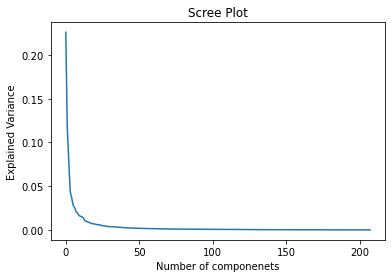

In [16]:
#Scree Plot
plt.plot(pca2.explained_variance_ratio_)
plt.title("Scree Plot")
plt.xlabel('Number of componenets')
plt.ylabel('Explained Variance')

Top k components explain 95% of the variance.


Text(0, 0.5, 'Cumulative Explained variance')

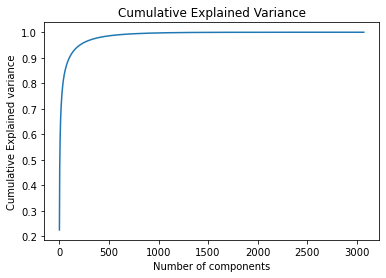

In [17]:
#Cumulative Explained Variance
print('Top k components explain {:.0f}% of the variance.'
 .format(100*pca2.explained_variance_ratio_.sum()))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Cumulative Explained Variance")
plt.xlabel('Number of components')
plt.ylabel('Cumulative Explained variance')

In [18]:
loadings = minmax_scale(pca.components_, feature_range=(0,1), axis=1)

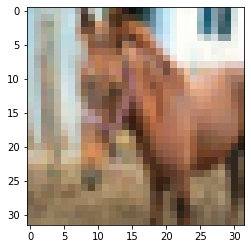

In [19]:
##image vs it's reconstruction using PCA
PCs = pca.transform(X_train)
X_recon = pca.inverse_transform(PCs).astype('int')
plt.imshow(X_train[0].reshape(32, 32, 3))

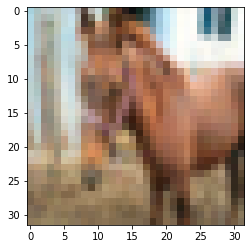

In [20]:
plt.imshow(X_recon[0].reshape(32, 32, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


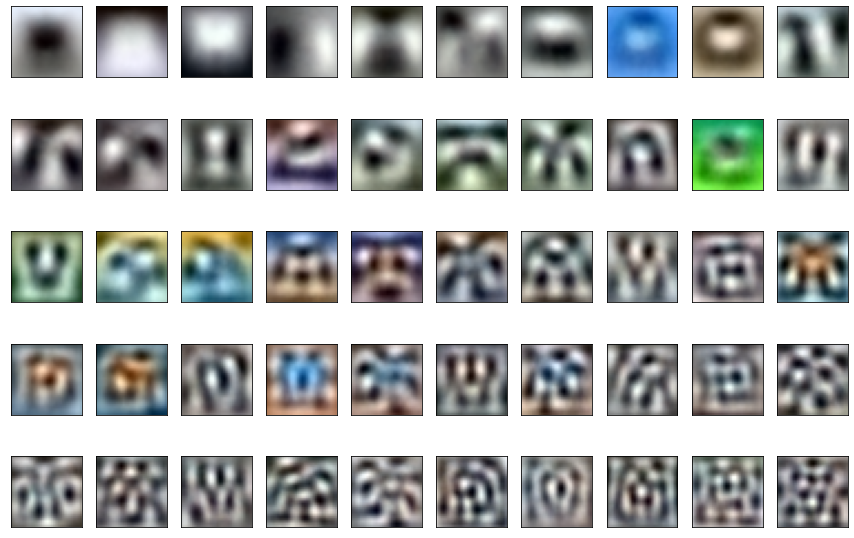

In [21]:
# Plot the top 50 PCA components
plt.figure(figsize=(15, 10))
for j in range(50):
    plt.subplot(5, 10, j + 1)
    plt.imshow(loadings[j].reshape(32, 32, 3))
    plt.xticks(())
    plt.yticks(())

### NMF

/Users/tt/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


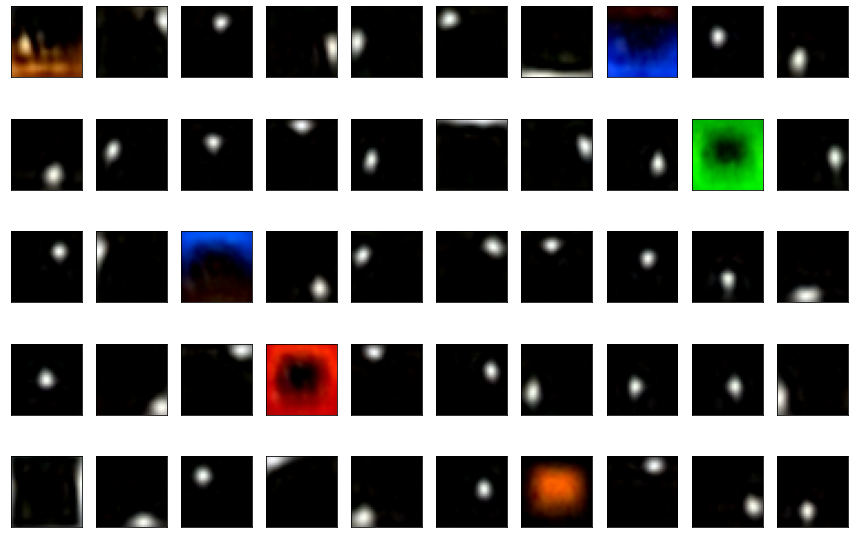

In [22]:
nmf = NMF(n_components=50).fit(X_train)
nmf_loadings = minmax_scale(nmf.components_, 
                            feature_range=(0,1), 
                            axis=1)

plt.figure(figsize=(15, 10))
for j in range(50):
    plt.subplot(5, 10, j + 1)
    plt.imshow(nmf_loadings[j].reshape(32, 32, 3))
    plt.xticks(())
    plt.yticks(())

NMF loadings seem to highlight different parts of the image. 

The ordering of the PC loadings are meaningful (they are ordered by variance explained). The ordering of
the NMF loadings are irrelevant

## 5. Initial Models

### 1) Random Forest and Gradient Boosted Decision Tree

In [23]:
#Initial random forest and gradient boosted decision tree models
rf = RandomForestClassifier()
gbdt = GradientBoostingClassifier()

# Initialize lists to hold metrics:
models = [rf, gbdt]
model_names = ['Random Forest', 'Gradient Boosted Tree']
train_accuracy=[]
test_accuracy=[]

In [24]:
#calculate the accuracy of Random Forest and Gradient Bossted 
#Decision Tree
for m in models:
    m.fit(X_train_pca, y_train.ravel())
    train_preds = m.predict(X_train_pca)
    test_preds = m.predict(X_test_pca)
    train_accuracy.append(accuracy_score(y_train, train_preds))
    test_accuracy.append(accuracy_score(y_test,test_preds))

In [25]:
#Compare the accuracy in train and test sets
accuracy = pd.DataFrame({'model':model_names,
             'Accuracy_train': train_accuracy,
             'Accuracy_test': test_accuracy})
accuracy

,model,Accuracy_train,Accuracy_test
0,Random Forest,1.00000,0.7515
1,Gradient Boosted Tree,0.84625,0.7815


As we can tell the Gradient Boosted Decision Trees has better acuuracy score in test set.
____

### 2) Fully-Connected Neural Networks

In [26]:
##Reshape the X
X_train = X_train.reshape(8000,32,32,3)
X_valid = X_valid.reshape(2000,32,32,3)
X_test = X_test.reshape(2000,32,32,3)

In [27]:
##One hot encoder y to categorical data
y_train_cnn = to_categorical(y_train,2)
y_valid_cnn = to_categorical(y_valid,2)
y_test_cnn = to_categorical(y_test,2)

In [28]:
##Fully-connected neural networks by using PCA components
model_NN = Sequential()
model_NN.add(Dense(50, activation = 'relu',
                   input_shape=(X_train_pca.shape[1],)))
model_NN.add(Dense(20, activation = 'relu'))
model_NN.add(Dense(2, activation = 'softmax'))

model_NN.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
history=model_NN.fit(X_train_pca, y_train_cnn, 
                     epochs=50, 
                     batch_size=100, 
                     validation_data=(X_valid_pca, y_valid_cnn))

Epoch 1/50
80/80 [==============================] - 0s 2ms/step - loss: 0.6906 - accuracy: 0.5965 - val_loss: 0.6016 - val_accuracy: 0.6820
Epoch 2/50
80/80 [==============================] - 0s 716us/step - loss: 0.5206 - accuracy: 0.7494 - val_loss: 0.5370 - val_accuracy: 0.7475
Epoch 3/50
80/80 [==============================] - 0s 718us/step - loss: 0.4462 - accuracy: 0.7951 - val_loss: 0.5219 - val_accuracy: 0.7520
Epoch 4/50
80/80 [==============================] - 0s 729us/step - loss: 0.3959 - accuracy: 0.8234 - val_loss: 0.5137 - val_accuracy: 0.7590
Epoch 5/50
80/80 [==============================] - 0s 713us/step - loss: 0.3545 - accuracy: 0.8486 - val_loss: 0.5142 - val_accuracy: 0.7630
Epoch 6/50
80/80 [==============================] - 0s 720us/step - loss: 0.3159 - accuracy: 0.8717 - val_loss: 0.5190 - val_accuracy: 0.7625
Epoch 7/50
80/80 [==============================] - 0s 724us/step - loss: 0.2776 - accuracy: 0.8923 - val_loss: 0.5246 - val_accuracy: 0.7710
Epoch 8/

In [29]:
NN_accuracy = model_NN.evaluate(X_test_pca, y_test_cnn)[1]
print(NN_accuracy)

63/63 [==============================] - 0s 648us/step - loss: 1.6741 - accuracy: 0.7760
0.7760000228881836


In [30]:
##Compare accuracy with the three models
accuracy.append({'model':'Neural Network','Accuracy_test':NN_accuracy}, ignore_index=True)

,model,Accuracy_train,Accuracy_test
0,Random Forest,1.00000,0.7515
1,Gradient Boosted Tree,0.84625,0.7815
2,Neural Network,NaN,0.7760


In [31]:
##Fully-connected neural networks without using PCA
model_NN2 = Sequential()
model_NN2.add(Flatten(input_shape=(32,32,3)))
model_NN2.add(Dense(50, activation = 'relu'))
model_NN2.add(Dense(20, activation='relu'))
model_NN2.add(Dense(2, activation='softmax'))

model_NN2.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
history=model_NN2.fit(X_train, y_train_cnn, 
                      epochs=50, batch_size=100, 
                      validation_data=(X_valid, y_valid_cnn))

Epoch 1/50
80/80 [==============================] - 0s 2ms/step - loss: 2.2755 - accuracy: 0.4996 - val_loss: 0.6963 - val_accuracy: 0.5035
Epoch 2/50
80/80 [==============================] - 0s 2ms/step - loss: 0.6874 - accuracy: 0.5483 - val_loss: 0.6811 - val_accuracy: 0.5815
Epoch 3/50
80/80 [==============================] - 0s 1ms/step - loss: 0.6674 - accuracy: 0.6037 - val_loss: 0.6653 - val_accuracy: 0.5935
Epoch 4/50
80/80 [==============================] - 0s 1ms/step - loss: 0.6429 - accuracy: 0.6451 - val_loss: 0.6360 - val_accuracy: 0.6525
Epoch 5/50
80/80 [==============================] - 0s 1ms/step - loss: 0.6180 - accuracy: 0.6752 - val_loss: 0.6252 - val_accuracy: 0.6540
Epoch 6/50
80/80 [==============================] - 0s 1ms/step - loss: 0.6069 - accuracy: 0.6758 - val_loss: 0.6092 - val_accuracy: 0.6795
Epoch 7/50
80/80 [==============================] - 0s 2ms/step - loss: 0.5888 - accuracy: 0.7015 - val_loss: 0.5965 - val_accuracy: 0.6775
Epoch 8/50
80/80 [==

In [32]:
model_NN2.evaluate(X_test, y_test_cnn)

63/63 [==============================] - 0s 708us/step - loss: 0.5236 - accuracy: 0.7475


[0.5235821604728699, 0.7475000023841858]

### 3) Convolutional Neural Networks (CNN)

In [52]:
model_CNN=Sequential()
model_CNN.add(Conv2D(32, 
                    kernel_size=(3,3),
                    strides=1, 
                    activation ='relu', 
                    padding='same', input_shape=(32,32,3)))
model_CNN.add(MaxPooling2D(pool_size=(2,2),strides=2))
model_CNN.add(Conv2D(64, 
                    kernel_size=(3,3),
                    strides=1, 
                    activation ='relu', 
                    padding='same'))
model_CNN.add(Flatten())
model_CNN.add(Dense(50, activation = 'relu'))
model_CNN.add(Dense(20, activation='relu'))
model_CNN.add(Dense(2, activation='softmax'))

In [53]:
model_CNN.compile(optimizer='adam',
              loss ='categorical_crossentropy',
              metrics=['accuracy'])
history_CNN = model_CNN.fit(X_train, y_train_cnn, 
                            epochs=50, batch_size=100, 
                            validation_data =(X_valid,y_valid_cnn))

Epoch 1/50
80/80 [==============================] - 4s 45ms/step - loss: 3.7811 - accuracy: 0.6819 - val_loss: 0.4947 - val_accuracy: 0.7660
Epoch 2/50
80/80 [==============================] - 3s 42ms/step - loss: 0.4472 - accuracy: 0.7918 - val_loss: 0.5077 - val_accuracy: 0.7590
Epoch 3/50
80/80 [==============================] - 3s 43ms/step - loss: 0.3803 - accuracy: 0.8314 - val_loss: 0.5098 - val_accuracy: 0.7780
Epoch 4/50
80/80 [==============================] - 3s 43ms/step - loss: 0.3293 - accuracy: 0.8589 - val_loss: 0.4722 - val_accuracy: 0.8115
Epoch 5/50
80/80 [==============================] - 3s 43ms/step - loss: 0.2806 - accuracy: 0.8764 - val_loss: 0.5084 - val_accuracy: 0.8065
Epoch 6/50
80/80 [==============================] - 3s 43ms/step - loss: 0.2609 - accuracy: 0.8924 - val_loss: 0.5321 - val_accuracy: 0.8140
Epoch 7/50
80/80 [==============================] - 3s 43ms/step - loss: 0.1953 - accuracy: 0.9221 - val_loss: 0.5801 - val_accuracy: 0.8065
Epoch 8/50
80

In [54]:
model_CNN.evaluate(X_test, y_test_cnn)

63/63 [==============================] - 0s 4ms/step - loss: 1.6902 - accuracy: 0.8435


[1.6902180910110474, 0.843500018119812]

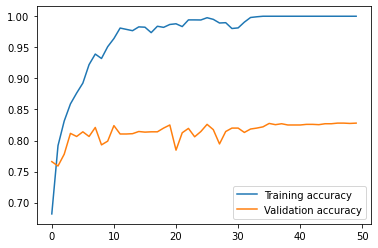

In [55]:
#Accuracy plot
plt.plot(history_CNN.history['accuracy'], 
         label='Training accuracy')
plt.plot(history_CNN.history['val_accuracy'], 
         label='Validation accuracy')
plt.legend()

In [56]:
## Compare NN without using PCA
pd.DataFrame({'model':['NN_PCA','NN_without/PCA','CNN'],
             'Accuracy_test':[NN_accuracy,
                              model_NN2.evaluate(X_test, 
                                                 y_test_cnn, 
                                                 verbose=0)[1], 
                              model_CNN.evaluate(X_test, 
                                                 y_test_cnn,
                                                 verbose=0)[1]]})

,model,Accuracy_test
0,NN_PCA,0.7760
1,NN_without/PCA,0.7475
2,CNN,0.8435


**Comparing with the accuracy of all the models, we go with convolutional neural networks.**
____

### Plot an example image and its feature maps

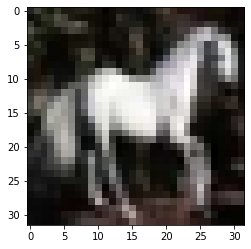

In [37]:
## CNN Example
img_index=1
example = X_test[img_index].reshape(32,32,3)
plt.imshow(example)

In [38]:
# Create list of layer outputs
layer_outputs = [layer.output for layer in model_CNN.layers] 

# Create a model that will return the outputs at each layer
layers_model = keras.Model(inputs=model_CNN.input, 
                           outputs=layer_outputs) 

# Get predictions for each layer of the network
outputs = layers_model.predict(example.reshape(1,32, 32,3)) 

<function matplotlib.pyplot.show(*args, **kw)>

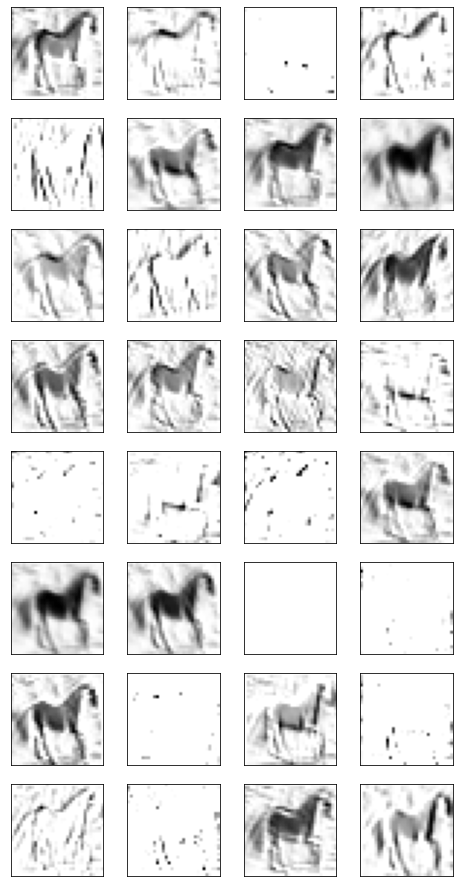

In [39]:
#Plot the first convolutional layer and its feature
layer = 0
n_col = 4
n_row = 8
plt.figure(figsize=(2*n_col, 2*n_row))
for j in range(n_row * n_col):
    plt.subplot(n_row, n_col, j + 1)
    plt.imshow(outputs[layer][0, :, :, j], plt.cm.binary)
    plt.xticks(())
    plt.yticks(())
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

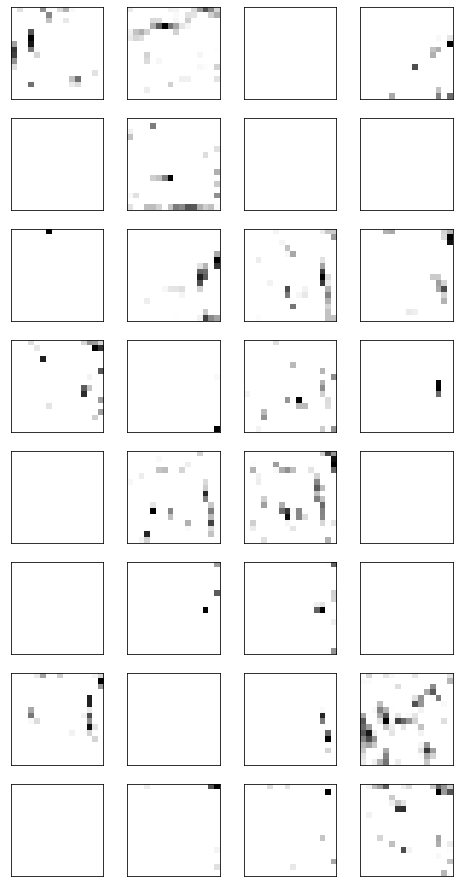

In [40]:
#Plot the second convolutional layer and its feature
layer = 2
n_col = 4
n_row = 8
plt.figure(figsize=(2*n_col, 2*n_row))
for j in range(n_row * n_col):
    plt.subplot(n_row, n_col, j + 1)
    plt.imshow(outputs[layer][0, :, :, j], plt.cm.binary)
    plt.xticks(())
    plt.yticks(())
plt.show

## 6. Model Optimization (CNN)
We are stacking convolutional layers with small 3×3 filters followed by a max pooling layer. Together, these layers form a block, and these blocks can be repeated where the number of filters in each block is increased with the depth of the network such as 32, 64, 128 for the first three blocks of the model. In addition, adding Dropout layers after each max pooling layer and after the fully connected layer, and using a fixed dropout rate of 20% (retain 80% of the nodes).

Then we increasing to 3 fully connected layers, and using L2 weight regularization 0.001 on dense layer 3.

Last, we are increasing batch size to 128.

In [41]:
model_opt =Sequential()
model_opt.add(Conv2D(32,
                     kernel_size=(3,3),
                     strides=1,
                     activation ='relu',
                     padding='same', input_shape=(32,32,3)))
model_opt.add(Conv2D(32,
                     kernel_size=(3,3),
                     strides=1,
                     activation ='relu',
                     padding='same'))
model_opt.add(MaxPooling2D(pool_size=(2,2),strides=2))
model_opt.add(Dropout(0.2))
model_opt.add(Conv2D(64,
                     kernel_size=(3,3),
                     strides=1,
                     activation ='relu',
                     padding='same'))
model_opt.add(Conv2D(64,
                     kernel_size=(3,3),
                     strides=1,
                     activation ='relu',
                     padding='same'))
model_opt.add(MaxPooling2D(pool_size=(2,2),strides=2))
model_opt.add(Dropout(0.2))
model_opt.add(Conv2D(128,
                     kernel_size=(3,3),
                     strides=1,
                     activation ='relu',
                     padding='same'))
model_opt.add(Conv2D(128,
                     kernel_size=(3,3),
                     strides=1,
                     activation ='relu',
                     padding='same'))
model_opt.add(MaxPooling2D(pool_size=(2,2),strides=2))
model_opt.add(Dropout(0.2))
model_opt.add(Flatten())
model_opt.add(Dense(128, activation = 'relu'))
model_opt.add(Dropout(0.2))
model_opt.add(Dense(50, activation = 'relu'))
model_opt.add(Dropout(0.2))
model_opt.add(Dense(20, activation = 'relu',
                    kernel_regularizer=keras.regularizers.l2(.001)))
model_opt.add(Dropout(0.2))
model_opt.add(Dense(2, activation='softmax'))

In [42]:
model_opt.compile(optimizer='adam',
              loss ='categorical_crossentropy',
              metrics=['accuracy'])
history_opt = model_opt.fit(X_train, y_train_cnn, 
                            epochs=50, batch_size=128, 
                            validation_data =(X_valid,y_valid_cnn))

Epoch 1/50
63/63 [==============================] - 15s 242ms/step - loss: 1.3179 - accuracy: 0.5167 - val_loss: 0.7214 - val_accuracy: 0.4570
Epoch 2/50
63/63 [==============================] - 15s 241ms/step - loss: 0.7199 - accuracy: 0.5159 - val_loss: 0.7104 - val_accuracy: 0.6495
Epoch 3/50
63/63 [==============================] - 15s 232ms/step - loss: 0.6939 - accuracy: 0.5863 - val_loss: 0.6788 - val_accuracy: 0.6440
Epoch 4/50
63/63 [==============================] - 15s 235ms/step - loss: 0.6258 - accuracy: 0.6800 - val_loss: 0.5268 - val_accuracy: 0.7645
Epoch 5/50
63/63 [==============================] - 15s 242ms/step - loss: 0.5502 - accuracy: 0.7464 - val_loss: 0.4981 - val_accuracy: 0.8030
Epoch 6/50
63/63 [==============================] - 15s 241ms/step - loss: 0.4945 - accuracy: 0.7865 - val_loss: 0.4095 - val_accuracy: 0.8370
Epoch 7/50
63/63 [==============================] - 15s 231ms/step - loss: 0.4582 - accuracy: 0.8126 - val_loss: 0.3882 - val_accuracy: 0.8495

In [43]:
#Accuracy on test set
model_opt.evaluate(X_test, y_test_cnn)

63/63 [==============================] - 1s 9ms/step - loss: 0.2768 - accuracy: 0.9090


[0.27681854367256165, 0.9089999794960022]

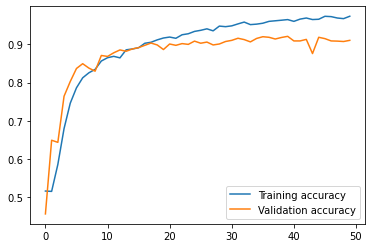

In [44]:
#Accuracy plot
plt.plot(history_opt.history['accuracy'], 
         label='Training accuracy')
plt.plot(history_opt.history['val_accuracy'], 
         label='Validation accuracy')
plt.legend()

### Plot an example image and its feature maps

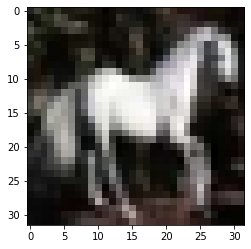

In [45]:
img_index=1
example = X_test[img_index].reshape(32,32,3)
plt.imshow(example)

In [46]:
# Create list of layer outputs
layer_outputs2 = [layer.output for layer in model_opt.layers] 

# Create a model that will return the outputs at each layer
layers_model2 = keras.Model(inputs=model_opt.input, 
                            outputs=layer_outputs2) 

# Get predictions for each layer of the network
outputs2 = layers_model2.predict(example.reshape(1,32, 32, 3)) 

<function matplotlib.pyplot.show(*args, **kw)>

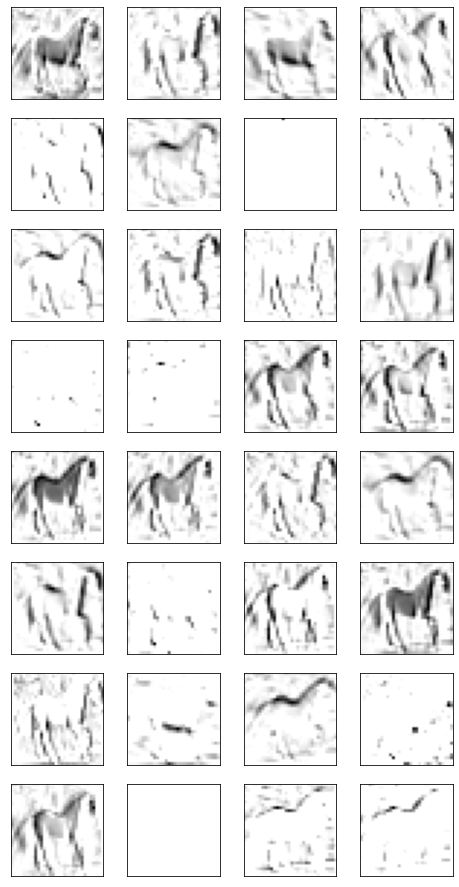

In [47]:
#Plot the first convolutional layer and its feature
layer = 0
n_col = 4
n_row = 8
plt.figure(figsize=(2*n_col, 2*n_row))
for j in range(n_row * n_col):
    plt.subplot(n_row, n_col, j + 1)
    plt.imshow(outputs2[layer][0, :, :, j], plt.cm.binary)
    plt.xticks(())
    plt.yticks(())
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

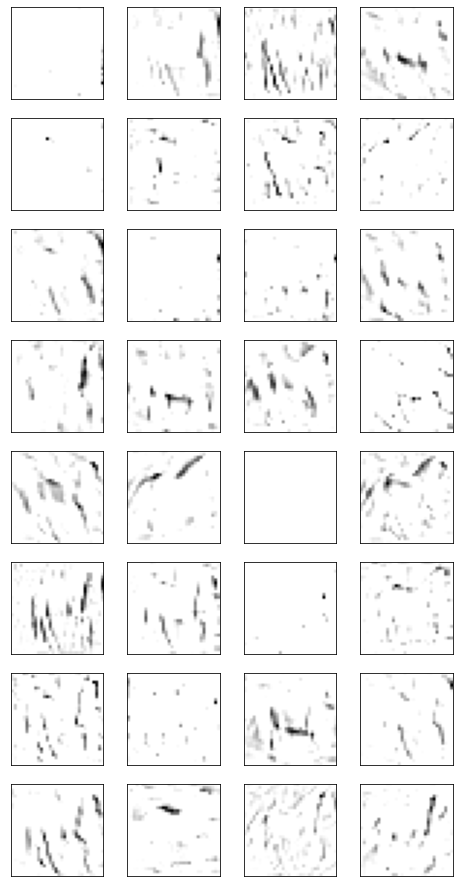

In [48]:
#Plot the second convolutional layer and its feature
layer = 1
n_col = 4
n_row = 8
plt.figure(figsize=(2*n_col, 2*n_row))
for j in range(n_row * n_col):
    plt.subplot(n_row, n_col, j + 1)
    plt.imshow(outputs2[layer][0, :, :, j], plt.cm.binary)
    plt.xticks(())
    plt.yticks(())
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

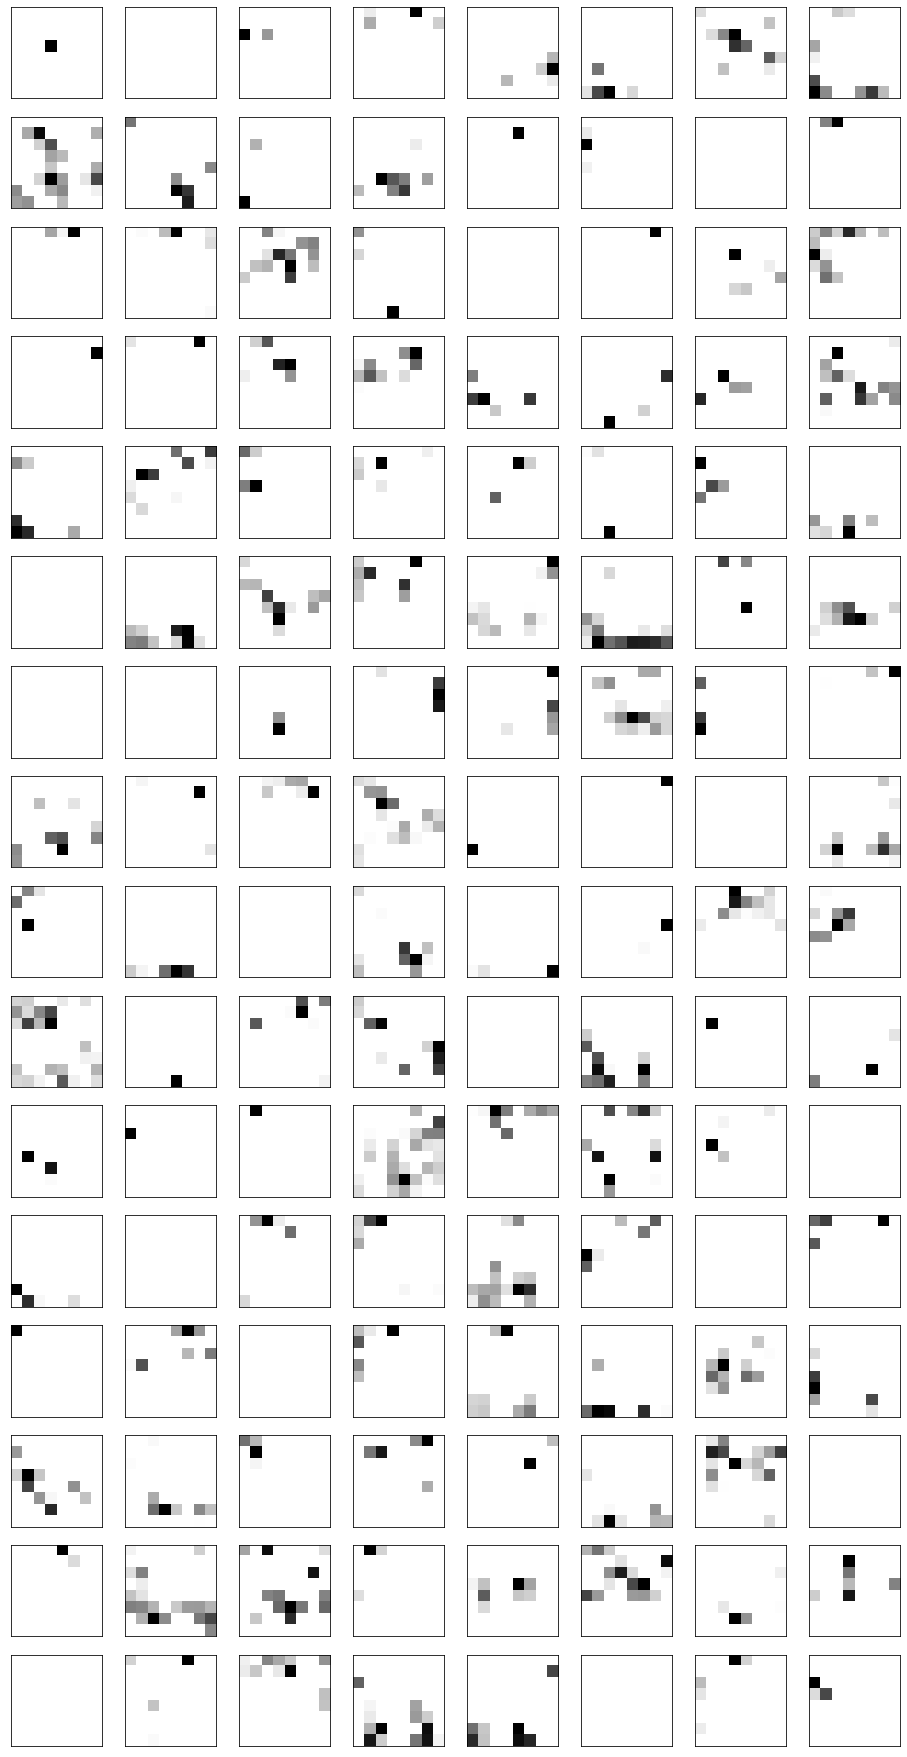

In [49]:
#Plot the last convolutional layer and its feature
layer = 9
n_col = 8
n_row = 16
plt.figure(figsize=(2*n_col, 2*n_row))
for j in range(n_row * n_col):
    plt.subplot(n_row, n_col, j + 1)
    plt.imshow(outputs2[layer][0, :, :, j], plt.cm.binary)
    plt.xticks(())
    plt.yticks(())
plt.show

## 7. Additional Code

### Function for CNN Image Classification

In [50]:
# # --------------------------------------------------------------------
# # Creating a function for building a CNN based on arguments supplied
# # --------------------------------------------------------------------
# def f_build_CNN(arg_X_train, arg_y_train, arg_X_test, arg_y_test, 
#                 arg_conv_layers,
#                 arg_pool_layers, 
#                 arg_out_layers, 
#                 arg_compile_parms,
#                 arg_fit_parms):
#     # --------------------------------------------------------------------
#     # Initializing the model
#     # --------------------------------------------------------------------
#     model = Sequential()
    
#     # --------------------------------------------------------------------
#     # Adding Convolution and Pool Layers alternatively
#     # --------------------------------------------------------------------
#     conv_layers = len(arg_conv_layers)
#     pool_layers = len(arg_pool_layers)
#     all_layers = conv_layers + pool_layers

#     conv_used = 0
#     pool_used = 0
#     prev_layer = None
#     curr_layer = None

#     for i in range(all_layers):
#         if i == 0 and prev_layer is None:
#             if conv_layers > 0:
#                 curr_layer = 'CONV' 
#                 conv_used = conv_used + 1
#             else:    
#                 curr_layer = 'POOL' 
#                 pool_used = pool_used + 1
#         elif prev_layer == 'POOL':
#             if conv_used < conv_layers:
#                 curr_layer = 'CONV'
#                 conv_used = conv_used + 1
#             else:
#                 curr_layer = 'POOL'
#                 pool_used = pool_used + 1
#         elif prev_layer == 'CONV':
#             if pool_used < pool_layers:
#                 curr_layer = 'POOL'
#                 pool_used = pool_used + 1
#             else:
#                 curr_layer = 'CONV'
#                 conv_used = conv_used + 1
#         else:
#             None

#         if curr_layer == 'CONV':
#             conv_layer = arg_conv_layers[conv_used - 1]
#             model.add(Conv2D(conv_layer[0], 
#                              kernel_size = conv_layer[1], 
#                              activation  = conv_layer[2], 
#                              padding     = conv_layer[3], 
#                              input_shape = conv_layer[4]))

#             #print('Current CONV Item : ', 
#                     arg_conv_layers[conv_used - 1])
#         else:
#             pool_layer = arg_pool_layers[pool_used - 1]
#             model.add(MaxPooling2D(pool_size = pool_layer[0], 
#                                    strides   = pool_layer[1]))
#             #print('Current POOL Item : ', 
#                     arg_pool_layers[pool_used - 1])

#         prev_layer = curr_layer
#         curr_layer = None
    
#     # --------------------------------------------------------------------
#     # Flattening the image data 
#     # --------------------------------------------------------------------
#     model.add(Flatten())

#     # --------------------------------------------------------------------
#     # Adding the output layer
#     # --------------------------------------------------------------------
#     for out_layer in arg_out_layers:    
#         model.add(Dense(out_layer[0], activation = out_layer[1]))
    
#     # --------------------------------------------------------------------
#     # Printing Model Structure
#     # --------------------------------------------------------------------
#     print(model.summary())

#     # --------------------------------------------------------------------
#     # Compiling the Model
#     # --------------------------------------------------------------------
#     model.compile(optimizer = arg_compile_parms[0][0], 
#                   loss      = arg_compile_parms[0][1], 
#                   metrics   = arg_compile_parms[0][2])

#     # --------------------------------------------------------------------
#     # Fitting the Model
#     # --------------------------------------------------------------------
#     model_history = model.fit(arg_X_train, 
#                           arg_y_train, 
#                           epochs  = arg_fit_parms[0][0], 
#                           batch_size = arg_fit_parms[0][1], 
#                           validation_data= (arg_X_test, arg_y_test))

#     # --------------------------------------------------------------------
#     # Printing the model metrics
#     # --------------------------------------------------------------------
#     model_accuracy=model.evaluate(arg_X_test, arg_y_test, verbose = 0)[1]
#     print('Model Accuracy is ', model_accuracy)
    
#     return(model)

### Function for Fully Connected NN Image Classification

In [51]:
# # --------------------------------------------------------------------
# # Creating a function for building a CNN based on arguments supplied
# # --------------------------------------------------------------------
# def f_build_ANN(arg_X_train, arg_y_train, arg_X_test, arg_y_test, 
#                 arg_in_layers,
#                 arg_out_layers, 
#                 arg_compile_parms,
#                 arg_fit_parms):
#     # --------------------------------------------------------------------
#     # Initializing the model
#     # --------------------------------------------------------------------
#     model = Sequential()
#     # -----------------------------------------------------------------------------------------------------------
#     # Neural Netwoek Architecture
#     # -----------------------------------------------------------------------------------------------------------

#     for in_layer in arg_in_layers:    
#         model.add(Dense(units = in_layer[0], 
#                        activation = in_layer[1],
#                        input_shape = in_layer[2])) 

#     model.add(Flatten())  
#     # --------------------------------------------------------------------
#     # Adding the output layer
#     # --------------------------------------------------------------------
#     for out_layer in arg_out_layers:    
#         model.add(Dense(out_layer[0], activation = out_layer[1]))    

#     # -----------------------------------------------------------------------------------------------------------
#     # Generating Model Summary
#     # -----------------------------------------------------------------------------------------------------------
#     model.summary()

#     # -----------------------------------------------------------------------------------------------------------
#     # Neural Netwoek Model Compilation
#     # -----------------------------------------------------------------------------------------------------------
#     #model.compile(optimizer = 'adam', 
#.                   loss = 'mean_squared_error', 
#                    metrics = ['mse'])
#     model.compile(optimizer = arg_compile_parms[0][0], 
#                   loss      = arg_compile_parms[0][1], 
#                   metrics   = arg_compile_parms[0][2])
#     # --------------------------------------------------------------------
#     # Fitting the Model
#     # --------------------------------------------------------------------
#     model_history = model.fit(arg_X_train, 
#                           arg_y_train, 
#                           epochs  = arg_fit_parms[0][0], 
#                           batch_size = arg_fit_parms[0][1], 
#                           validation_data=(arg_X_test, arg_y_test))

#     # --------------------------------------------------------------------
#     # Printing the model Accuracy
#     # --------------------------------------------------------------------
#     model_accuracy = model.evaluate(X_test, y_test, verbose = 0)[1]
#     print('Model Accuracy is ', model_accuracy)

#     return model